In [2]:
import pandas as pd

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 20, 6
rcParams['lines.linewidth'] = 2.5

# Data

In [41]:
GHI_cs = pd.read_csv('data/Ineichen_clear_sky_model.csv', index_col='Unnamed: 0')[:'2023-06-01 01']

In [34]:
GHI_cs = pd.read_csv('/Users/yaizabermudez/internship/data_stage/PVLIB/Ineichen_clear-sky_model.csv', index_col='Unnamed: 0')[:'2023-06-01 01']


In [42]:
GHI_cs = GHI_cs.drop('dhi', axis = 1)
GHI_cs = GHI_cs.drop('dni', axis = 1)

In [43]:
GHI_m = pd.read_csv('data/Rayonnement solaire-data-2023-06-13 09_46_08.csv', index_col='Time')[:'2023-06-01 01']

In [44]:
GHI_m.columns = ['ghi_m']

In [45]:
GHI_cs.index = pd.to_datetime(GHI_cs.index, format ='%Y-%m-%d %H:%M:%S') 
GHI_cs =GHI_cs.tz_convert('Europe/Paris').tz_localize(None)

In [46]:
GHI_m.index = pd.to_datetime(GHI_m.index, format ='%Y-%m-%d %H:%M:%S')
GHI_m = GHI_m.tz_localize('UTC').tz_localize(None)

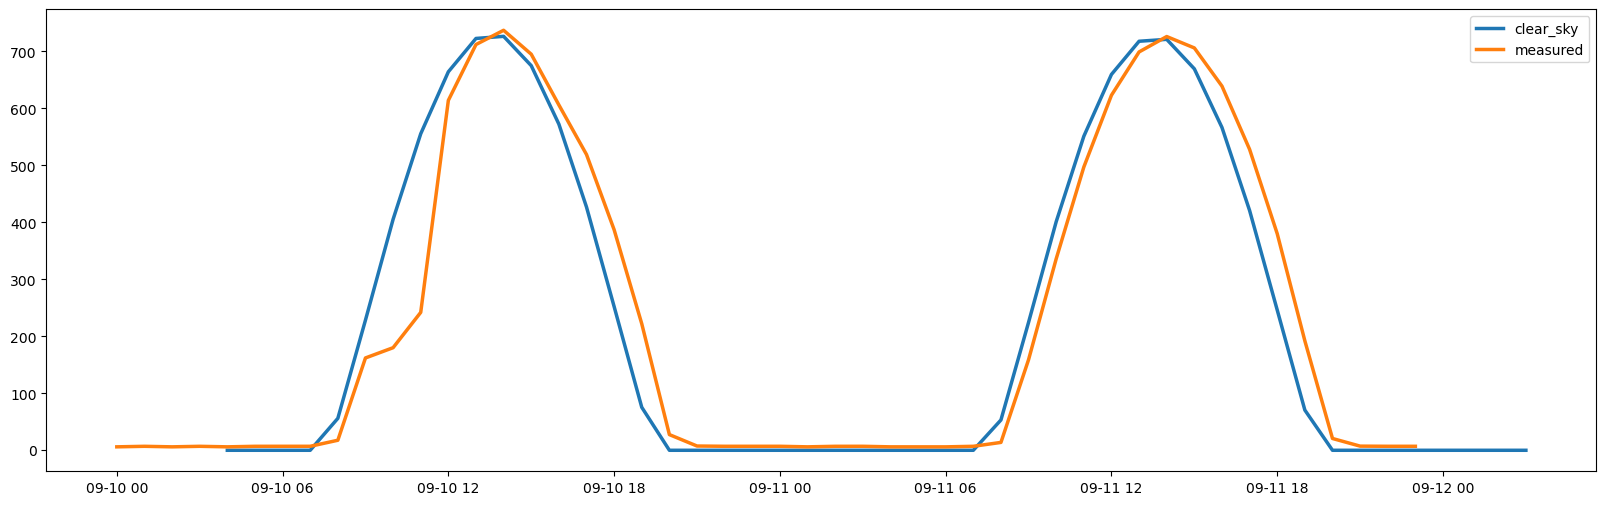

In [47]:
plt.plot(GHI_cs[:48], label='clear_sky')
plt.plot(GHI_m[:48], label='measured')
plt.legend()
plt.show()

In [31]:
GHI_m = GHI_m['2022-09-10 04:00:00':'2023-06-01 00']

In [16]:
GHI_cs = GHI_cs['2022-09-10 04:00:00':'2023-06-01 00']

In [17]:
neb =pd.read_csv("data/neb.csv", index_col='Date')

In [18]:
GHI_cs/= 1000
GHI_m/=1000

In [19]:
neb.index = pd.to_datetime(neb.index, format ='%Y-%m-%d %H:%M:%S')
neb= neb ['2022-09-10 04:00:00':'2023-06-01 00']

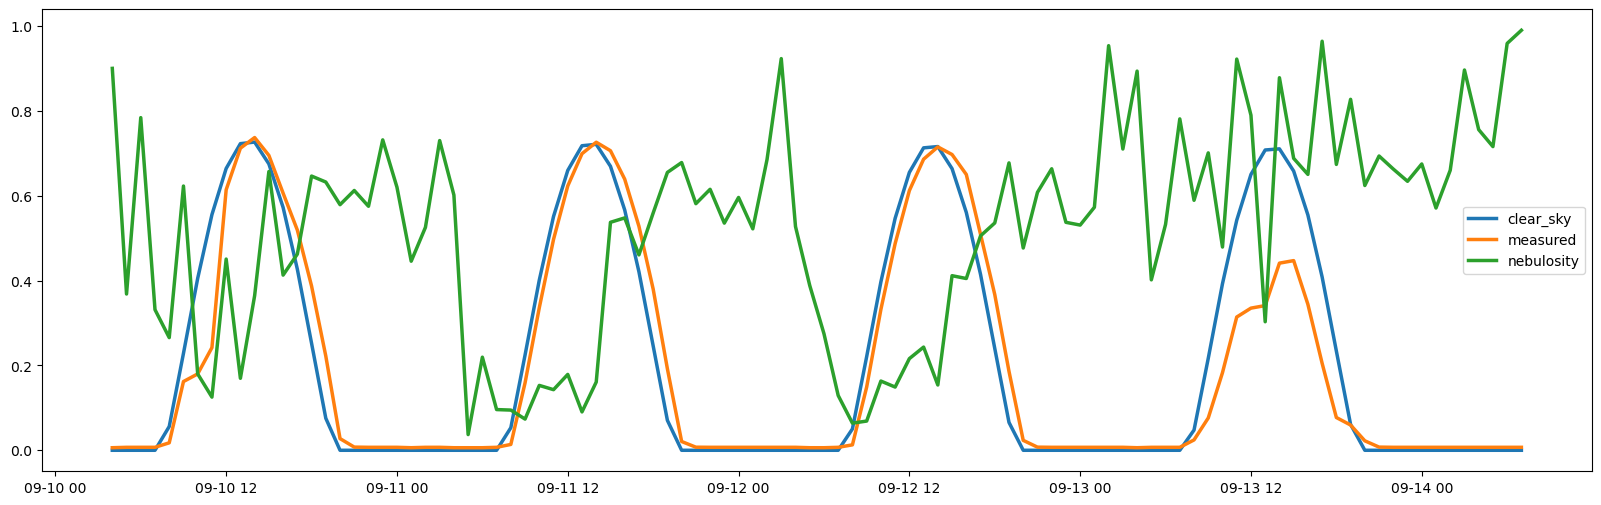

In [20]:
plt.plot(GHI_cs[:100], label='clear_sky')
plt.plot(GHI_m[:100], label='measured')
plt.plot(neb[:100], label = 'nebulosity')
plt.legend()
plt.show()

In [21]:
neb.index = GHI_cs.index
GHI_m.index = GHI_cs.index

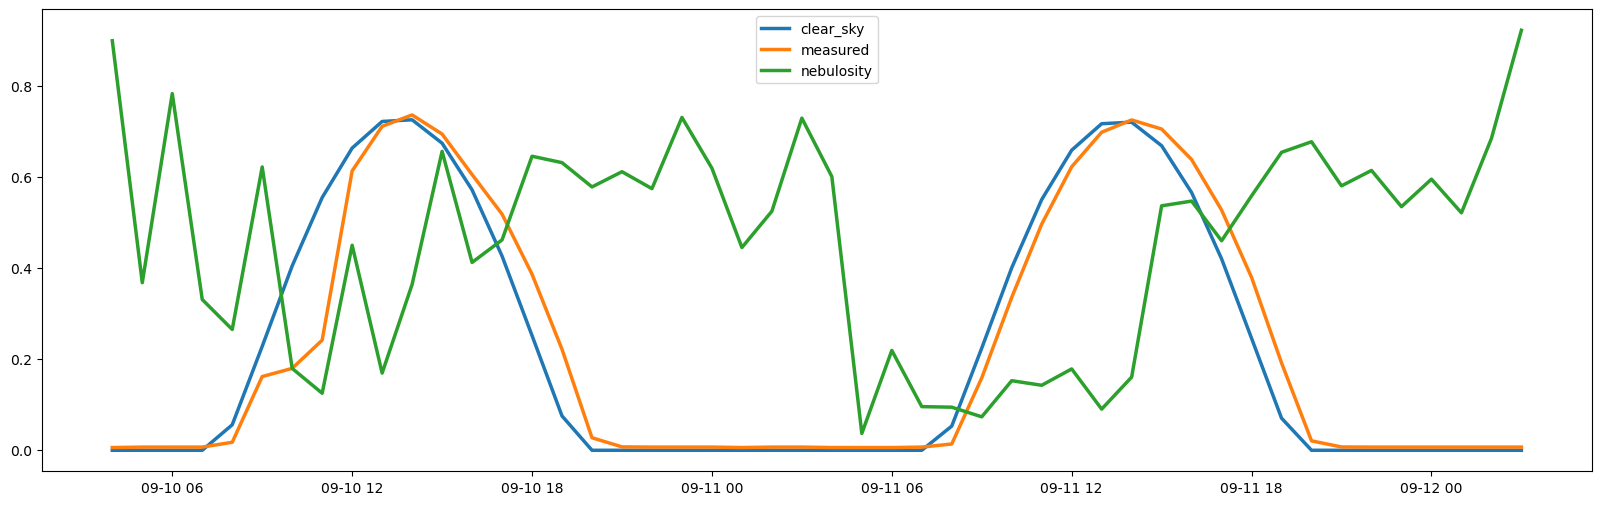

In [22]:
plt.plot(GHI_cs[:48], label='clear_sky')
plt.plot(GHI_m[:48], label='measured')
plt.plot(neb[:48], label = 'nebulosity')
plt.legend()
plt.show()

In [23]:
df = neb.copy()
df['ghi_m'] = GHI_m['ghi_m']
df['ghi_cs'] = GHI_cs['ghi']

# Neural Network approach

## Train to find a and n 

In [121]:
df_ = df.to_numpy()
df_ = torch.tensor(df_, dtype=torch.float32)
my_dataset = TensorDataset(df_) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=24)

In [122]:
train = df[:]

In [123]:
X_train = torch.tensor(train.values, dtype=torch.float32)

In [124]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3, 24)
        self.hidden2 = nn.Linear(24, 24)
        self.output1 = nn.Linear(24, 1)
        self.output2 = nn.Linear(24, 1)
 
 
    def forward(self, x):
        x = (self.hidden1(x))
        x =(self.hidden2(x))
        output1 = (self.output1(x))
        output2 = (self.output2(x))
        return output1, output2

In [125]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (hidden1): Linear(in_features=3, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=24, bias=True)
  (output1): Linear(in_features=24, out_features=1, bias=True)
  (output2): Linear(in_features=24, out_features=1, bias=True)
)


In [126]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [127]:
n_epochs = 100
batch_size = 24
 
for epoch in range(n_epochs):
    for index in my_dataloader:
        # print(index)
        y_pred = model(index[0])
        a, n1 = y_pred
        # calculating squared difference between target and predicted values 
        diff = torch.square(index[0][:,1] - (1- (a * torch.pow(index[0][:,0], n1)))* index[0][:,2])
        loss = torch.sum(diff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 9.670365333557129
Finished epoch 1, latest loss 8.635977745056152
Finished epoch 2, latest loss 7.841009616851807
Finished epoch 3, latest loss 7.095394611358643
Finished epoch 4, latest loss 6.611196041107178
Finished epoch 5, latest loss 6.409732818603516
Finished epoch 6, latest loss 6.391297817230225
Finished epoch 7, latest loss 6.443937301635742
Finished epoch 8, latest loss 6.508870601654053
Finished epoch 9, latest loss 6.566762447357178
Finished epoch 10, latest loss 6.615936756134033
Finished epoch 11, latest loss 6.6587982177734375
Finished epoch 12, latest loss 6.696347713470459
Finished epoch 13, latest loss 6.730888366699219
Finished epoch 14, latest loss 6.764215469360352
Finished epoch 15, latest loss 6.797677516937256
Finished epoch 16, latest loss 6.831071853637695
Finished epoch 17, latest loss 6.864748954772949
Finished epoch 18, latest loss 6.89674711227417
Finished epoch 19, latest loss 6.924785614013672
Finished epoch 20, latest loss

Test on trained data

In [128]:
a_, n_ = model(X_train)

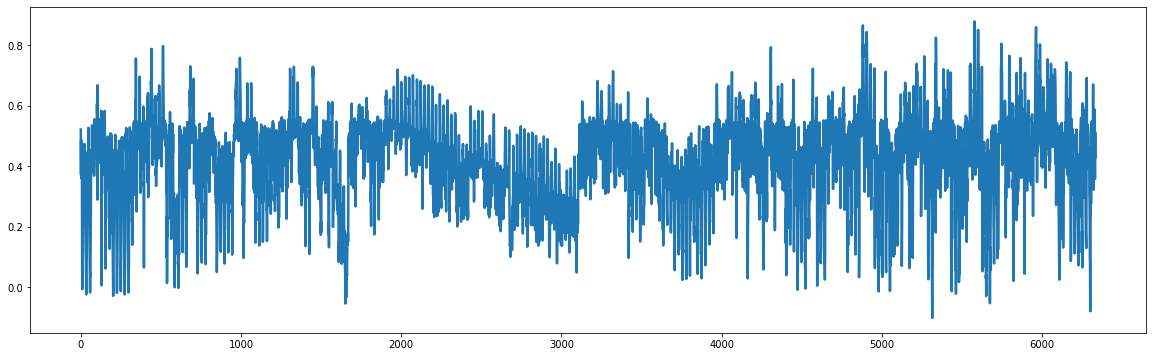

In [129]:
plt.plot(a_.detach().numpy().flatten(), label = 'a')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


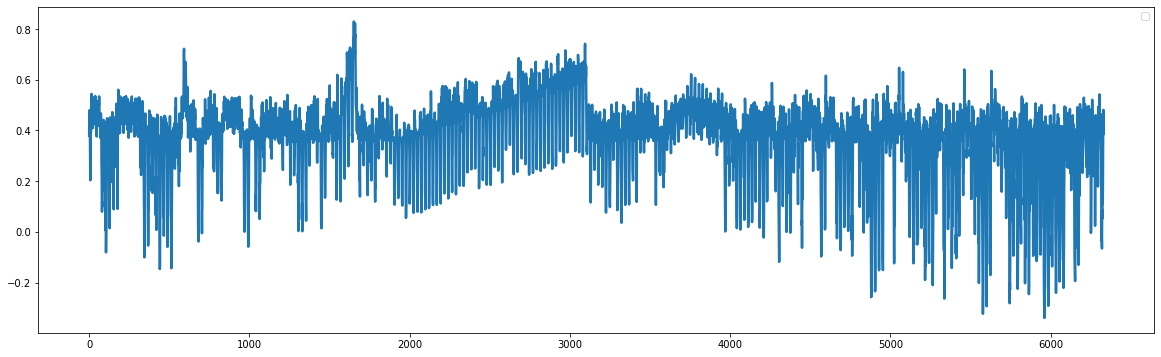

In [130]:

plt.plot(n_.detach().numpy().flatten())
plt.legend()
plt.show()

In [131]:
len(a_)

6333

In [132]:
ghi_cs = df['ghi_cs']

In [133]:
neb = df[' nebulosity']

In [134]:
pred = GHI_cs.copy()
pred.columns = ['pred_']

In [135]:
pred

,pred_
2022-09-10 04:00:00,0.000000
2022-09-10 05:00:00,0.000000
2022-09-10 06:00:00,0.000000
2022-09-10 07:00:00,0.000000
2022-09-10 08:00:00,0.056038
...,...
2023-05-31 20:00:00,0.095277
2023-05-31 21:00:00,0.000876
2023-05-31 22:00:00,0.000000
2023-05-31 23:00:00,0.000000


In [136]:
pred['pred_'] = ((1-a_.detach().numpy().flatten()*np.power(neb.to_numpy(), n_.detach().numpy().flatten()))* ghi_cs.to_numpy())*1000

In [137]:
true = GHI_m*1000

In [138]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 83.44 RMSE
RMSE en % :  9.250554678078638


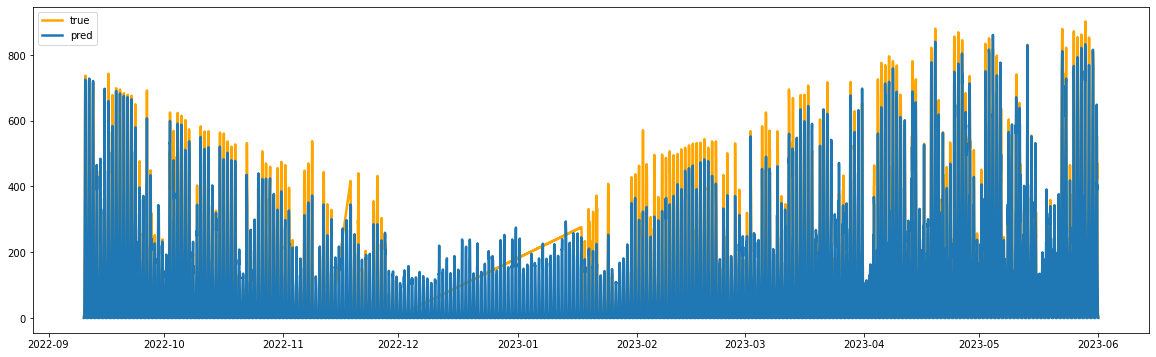

In [139]:
plt.plot(true, label = 'true', color = 'orange')
plt.plot(pred, label = 'pred')
plt.legend()
plt.show()


In [140]:
# torch.save(model.state_dict(), 'models/model_ss_fact_bis.pth')

## Train to find nebulosity
Try to predict the nebulosity with the above predicted a and n 

In [141]:
a_val = a_.detach().numpy().flatten()
n_val = n_.detach().numpy().flatten()

In [142]:
df_neb = df.drop(' nebulosity', axis=1)
df_neb['a'] = a_val
df_neb['n'] = n_val

In [143]:
df_neb

,ghi_m,ghi_cs,a,n
2022-09-10 04:00:00,0.00603,0.000000,0.521932,0.379336
2022-09-10 05:00:00,0.00697,0.000000,0.372616,0.473424
2022-09-10 06:00:00,0.00700,0.000000,0.488558,0.400551
2022-09-10 07:00:00,0.00700,0.000000,0.362272,0.479933
2022-09-10 08:00:00,0.01760,0.056038,0.362824,0.448531
...,...,...,...,...
2023-05-31 20:00:00,0.05070,0.095277,0.445862,0.380850
2023-05-31 21:00:00,0.01460,0.000876,0.384350,0.467383
2023-05-31 22:00:00,0.00712,0.000000,0.360473,0.481093
2023-05-31 23:00:00,0.00700,0.000000,0.513572,0.384827


In [23]:
df_neb_ = df_neb.to_numpy()
df_neb_ = torch.tensor(df_neb_, dtype=torch.float32)
my_dataset_neb = TensorDataset(df_neb_) # create your datset
my_dataloader_neb = DataLoader(my_dataset_neb, batch_size=24)

NameError: name 'df_neb' is not defined

In [145]:
train = df_neb[:]

In [146]:
X_train = torch.tensor(train.values, dtype=torch.float32)

In [147]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden1 = nn.Linear(4, 24)
#         self.act1 = nn.ReLU()
#         self.hidden2 = nn.Linear(24, 24)
#         self.act2 = nn.ReLU()
#         self.output1 = nn.Linear(24, 1)
#         self.act_output1 = nn.ReLU()

 
#     def forward(self, x):
#         x = self.act1(self.hidden1(x))
#         x = self.act2(self.hidden2(x))
#         output1 = self.act_output1(self.output1(x))
#         return output1

In [148]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 24)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(24, 24)
        self.act2 = nn.ReLU()
        self.output1 = nn.Linear(24, 1)
        self.act_output1 = nn.ReLU()

 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        output1 = self.act_output1(self.output1(x))
        return output1

In [149]:
model2 = NeuralNetwork2()
print(model2)

NeuralNetwork2(
  (hidden1): Linear(in_features=4, out_features=24, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=24, out_features=24, bias=True)
  (act2): ReLU()
  (output1): Linear(in_features=24, out_features=1, bias=True)
  (act_output1): ReLU()
)


In [150]:
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

In [151]:
n_epochs = 100
batch_size = 24
 
for epoch in range(n_epochs):
    for index in my_dataloader_neb:
        y_pred = model2(index[0])
        # print(torch.isnan(y_pred))
        # calculating squared difference between target and predicted values 
        diff = torch.square(index[0][:,0] - (1- (index[0][:,2] * torch.pow(y_pred, index[0][:,3])))* index[0][:,1])
        loss = torch.sum(diff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 2.226487398147583
Finished epoch 1, latest loss 2.1591830253601074
Finished epoch 2, latest loss 2.118936777114868
Finished epoch 3, latest loss 2.0913543701171875
Finished epoch 4, latest loss 2.0710649490356445
Finished epoch 5, latest loss 2.0557169914245605
Finished epoch 6, latest loss 2.04443097114563
Finished epoch 7, latest loss 2.036203622817993
Finished epoch 8, latest loss 2.0302748680114746
Finished epoch 9, latest loss 2.0259528160095215
Finished epoch 10, latest loss 2.022901773452759
Finished epoch 11, latest loss 2.0207972526550293
Finished epoch 12, latest loss 2.019545316696167
Finished epoch 13, latest loss 2.0189805030822754
Finished epoch 14, latest loss 2.019028663635254
Finished epoch 15, latest loss 2.01934814453125
Finished epoch 16, latest loss 2.0198440551757812
Finished epoch 17, latest loss 2.0203158855438232
Finished epoch 18, latest loss 2.020585060119629
Finished epoch 19, latest loss 2.0207509994506836
Finished epoch 20, la

Test on trained data

In [152]:
neb_ = model2(X_train)

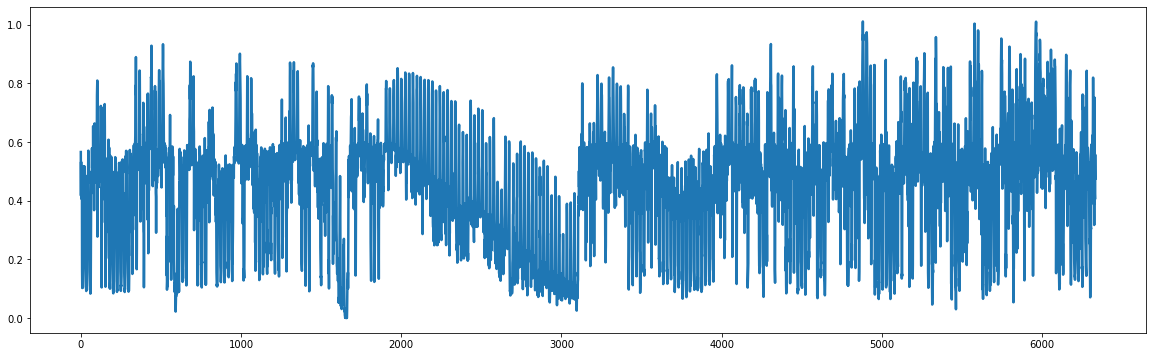

In [153]:
plt.plot(neb_.detach().numpy().flatten())

In [154]:
ghi_cs = df_neb['ghi_cs']

In [155]:
pred = GHI_cs.copy()
pred.columns = ['pred_']

In [156]:
pred['pred_'] = ((1-a_val*np.power(neb_.detach().numpy().flatten(), n_val))* ghi_cs.to_numpy())*1000

In [157]:
true = GHI_m*1000

In [158]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 78.65 RMSE
RMSE en % :  8.719120205303494


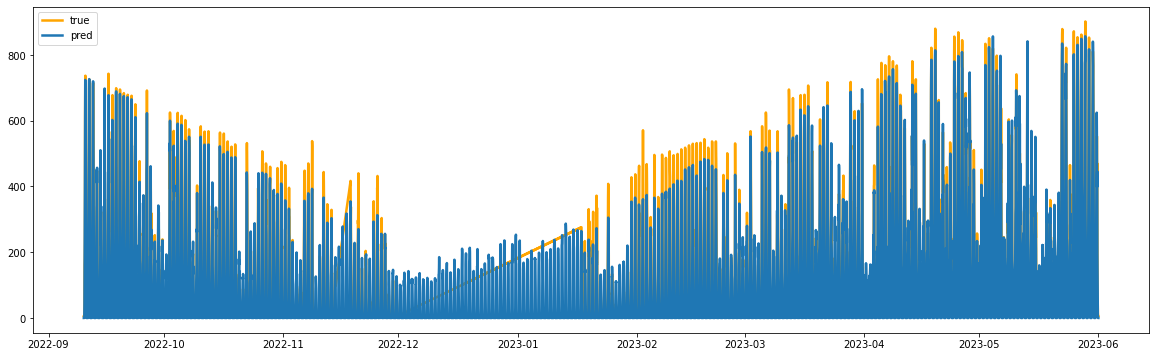

In [159]:
plt.plot(true, label = 'true', color = 'orange')
plt.plot(pred, label = 'pred')
plt.legend()
plt.show()


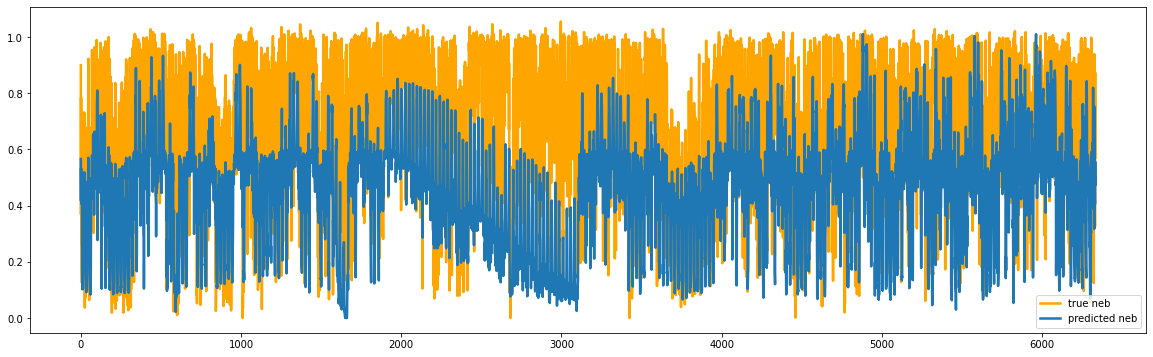

In [160]:
plt.plot(df[' nebulosity'].values, color = 'orange', label = 'true neb')
plt.plot(neb_.detach().numpy().flatten(), label = 'predicted neb')
plt.legend()

In [161]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(df[' nebulosity'].values, neb_.detach().numpy().flatten()))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/df[' nebulosity'].values.max())

Test Score: 0.34 RMSE
RMSE en % :  32.679083606424506


## Remove missing data 

In [22]:
df_neb_feb = df_neb['2023-02-01':]
df_neb_feb

NameError: name 'df_neb' is not defined

In [72]:
df_neb_feb_ = df_neb_feb.to_numpy()
df_neb_feb_ = torch.tensor(df_neb_feb_, dtype=torch.float32)
my_dataset_nebfeb_ = TensorDataset(df_neb_feb_) # create your datset
my_dataloader_nebfeb_ = DataLoader(my_dataset_nebfeb_, batch_size=24)

In [73]:
train = df_neb_feb[:]

In [74]:
X_train = torch.tensor(train.values, dtype=torch.float32)

In [75]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden1 = nn.Linear(4, 24)
#         self.act1 = nn.ReLU()
#         self.hidden2 = nn.Linear(24, 24)
#         self.act2 = nn.ReLU()
#         self.output1 = nn.Linear(24, 1)
#         self.act_output1 = nn.ReLU()

 
#     def forward(self, x):
#         x = self.act1(self.hidden1(x))
#         x = self.act2(self.hidden2(x))
#         output1 = self.act_output1(self.output1(x))
#         return output1

In [76]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 24)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(24, 24)
        self.act2 = nn.ReLU()
        self.output1 = nn.Linear(24, 1)
        self.act_output1 = nn.ReLU()

 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        output1 = self.act_output1(self.output1(x))
        return output1

In [77]:
model2 = NeuralNetwork2()
print(model2)

NeuralNetwork2(
  (hidden1): Linear(in_features=4, out_features=24, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=24, out_features=24, bias=True)
  (act2): ReLU()
  (output1): Linear(in_features=24, out_features=1, bias=True)
  (act_output1): ReLU()
)


In [78]:
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

In [79]:
n_epochs = 100
batch_size = 24
 
for epoch in range(n_epochs):
    for index in my_dataloader_nebfeb_:
        y_pred = model2(index[0])
        # calculating squared difference between target and predicted values 
        diff = torch.square(index[0][:,0] - (1- (index[0][:,2] * torch.pow(y_pred, index[0][:,3])))* index[0][:,1])
        loss = torch.sum(diff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 2.8106777667999268
Finished epoch 1, latest loss 2.7431347370147705
Finished epoch 2, latest loss 2.6919612884521484
Finished epoch 3, latest loss 2.65081787109375
Finished epoch 4, latest loss 2.61637282371521
Finished epoch 5, latest loss 2.58671498298645
Finished epoch 6, latest loss 2.5611202716827393
Finished epoch 7, latest loss 2.5389442443847656
Finished epoch 8, latest loss 2.5196821689605713
Finished epoch 9, latest loss 2.502556085586548
Finished epoch 10, latest loss 2.4873335361480713
Finished epoch 11, latest loss 2.473924398422241
Finished epoch 12, latest loss 2.462249994277954
Finished epoch 13, latest loss 2.452291965484619
Finished epoch 14, latest loss 2.4433610439300537
Finished epoch 15, latest loss 2.435647487640381
Finished epoch 16, latest loss 2.4292173385620117
Finished epoch 17, latest loss 2.4240572452545166
Finished epoch 18, latest loss 2.419978618621826
Finished epoch 19, latest loss 2.4167706966400146
Finished epoch 20, lat

Test on trained data

In [80]:
nebfeb_ = model2(X_train)

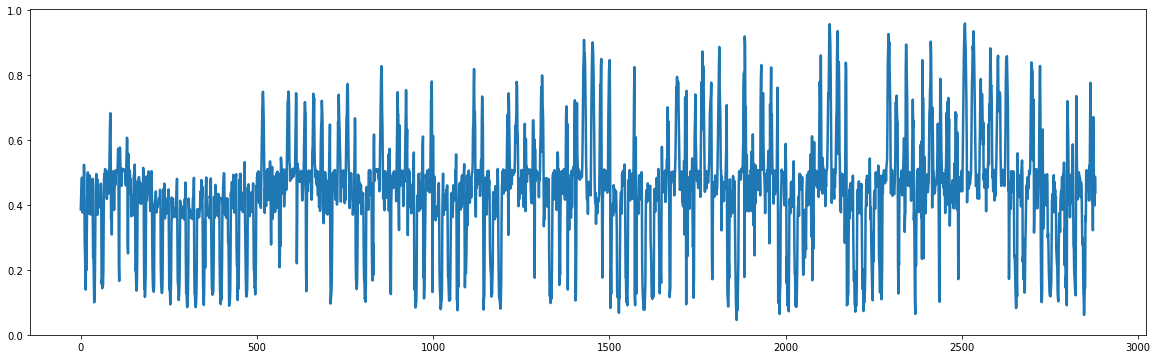

In [81]:
plt.plot(nebfeb_.detach().numpy().flatten())

In [82]:
ghi_cs = df_neb_feb['ghi_cs']

In [83]:
a = df_neb_feb['a']
n = df_neb_feb['n']

In [84]:
pred = GHI_cs.copy()['2023-02-01':]
pred.columns = ['pred_']

In [85]:
pred

,pred_
2023-02-01 00:00:00,0.000000
2023-02-01 01:00:00,0.000000
2023-02-01 02:00:00,0.000000
2023-02-01 03:00:00,0.000000
2023-02-01 04:00:00,0.000000
...,...
2023-05-31 20:00:00,0.095277
2023-05-31 21:00:00,0.000876
2023-05-31 22:00:00,0.000000
2023-05-31 23:00:00,0.000000


In [86]:
pred['pred_'] = ((1-a.to_numpy()*np.power(nebfeb_.detach().numpy().flatten(), n.to_numpy()))* ghi_cs.to_numpy())*1000

In [87]:
true = GHI_m['2023-02-01':]*1000

In [88]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 51.18 RMSE
RMSE en % :  5.673916008006291


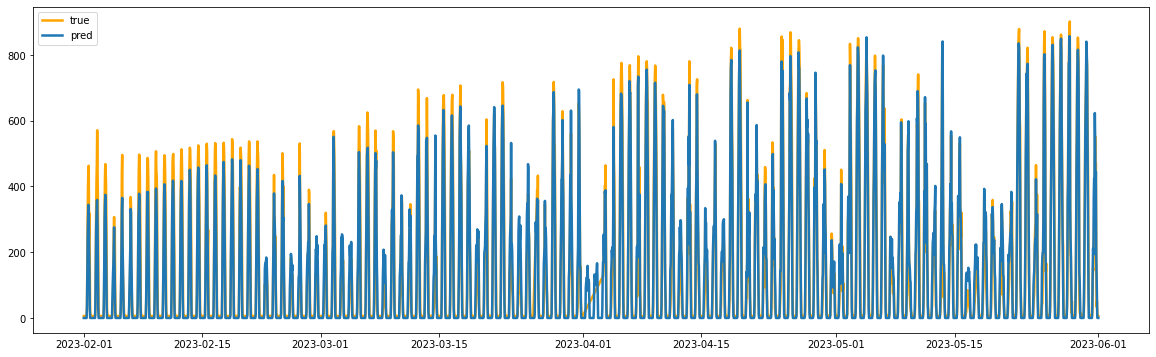

In [89]:
plt.plot(true, label = 'true', color = 'orange')
plt.plot(pred, label = 'pred')
plt.legend()
plt.show()


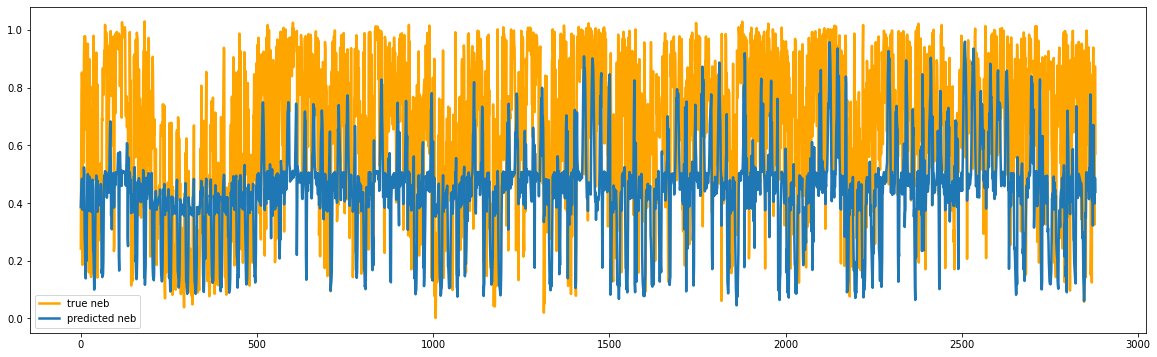

In [90]:
plt.plot(df[' nebulosity']['2023-02-01':].values, color = 'orange', label = 'true neb')
plt.plot(nebfeb_.detach().numpy().flatten(), label = 'predicted neb')
plt.legend()

# Particules Swarm Optimization approach

## First try for a and n optimization

In [187]:
from pyswarm import pso

In [188]:
def loss_func(x):
    a = x[0]
    n = x[1]
    diff = np.square(df['ghi_m'] - (1- (a * np.power(df[' nebulosity'], n)))* df['ghi_cs'] )
    loss = np.sum(diff)
    return loss

lb = [-1, -1]
ub = [1, 1]

xopt, fopt = pso(loss_func, lb, ub)

Stopping search: Swarm best objective change less than 1e-08


In [189]:
xopt

array([0.45519356, 0.58894557])

In [190]:
fopt

89.08526263093518

In [191]:
a = xopt[0]
n = xopt[1]

In [24]:
pred = GHI_cs.copy()
pred.columns = ['pred_']

In [25]:
pred

,pred_
2022-09-10 04:00:00,0.000000
2022-09-10 05:00:00,0.000000
2022-09-10 06:00:00,0.000000
2022-09-10 07:00:00,0.000000
2022-09-10 08:00:00,0.056038
...,...
2023-05-31 20:00:00,0.095277
2023-05-31 21:00:00,0.000876
2023-05-31 22:00:00,0.000000
2023-05-31 23:00:00,0.000000


In [195]:
pred['pred_'] = ((1-a*np.power(df[' nebulosity'].values, n))* df['ghi_cs'].to_numpy())*1000

In [198]:
true =GHI_m*1000

In [199]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 118.60 RMSE
RMSE en % :  13.148967464908038


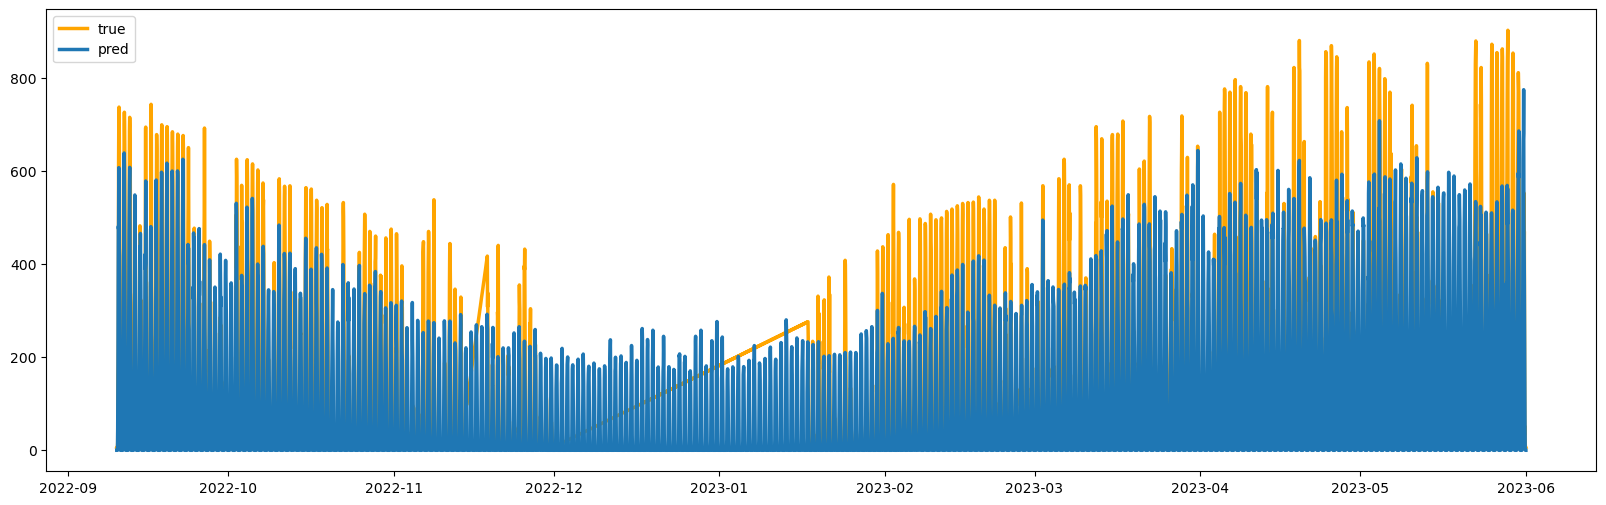

In [200]:
plt.plot(true, label = 'true', color = 'orange')
plt.plot(pred, label = 'pred')
plt.legend()
plt.show()


Here we only get one a and n but we would like to have one per hour less try again

## One per hour

In [216]:
def loss_func(x):
    a = x[0]
    n = x[1]
    diff = np.square(df['ghi_m'][index:index] - (1- (a * np.power(df[' nebulosity'][index:index], n)))* df['ghi_cs'][index:index])
    loss = np.sum(diff)
    return loss

lb = [-1, -1]
ub = [1, 1]
xa = []
xn = []
for index, row in df[:'2022-09-10'].iterrows():
    # print(df[index:index])
    xopt, fopt = pso(loss_func, lb, ub)
    xa.append(xopt[0])
    xn.append(xopt[1])

Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: 

In [217]:
xa

[-0.5153731394547398,
 -0.5533610670335654,
 0.19904789776176002,
 0.9731336669445831,
 0.3868624031734457,
 0.24549551310100076,
 0.17409083726245456,
 0.8989470910702572,
 0.11705248413031273,
 0.08747671358103061,
 -0.024172443952182366,
 -0.036941633251206085,
 -0.11838788258054764,
 -0.41643600551823323,
 -0.6468021115381246,
 -1.0,
 -0.11149099933272177,
 -0.826273371843631,
 -0.642359871322383,
 -0.99812032737818]

In [218]:
len(xa)

20

In [219]:
len(xn)

20

In [ ]:
fopt

89.08526263093518

In [ ]:
a = xopt[0]
n = xopt[1]

In [220]:
pred = GHI_cs[:'2022-09-10'].copy()
pred.columns = ['pred_']

In [221]:
pred

,pred_
2022-09-10 04:00:00,0.000000
2022-09-10 05:00:00,0.000000
2022-09-10 06:00:00,0.000000
2022-09-10 07:00:00,0.000000
2022-09-10 08:00:00,0.056038
2022-09-10 09:00:00,0.228406
2022-09-10 10:00:00,0.405246
2022-09-10 11:00:00,0.555382
2022-09-10 12:00:00,0.664162
2022-09-10 13:00:00,0.722665


In [222]:
pred['pred_'] = ((1-xa*np.power(df[' nebulosity'][:'2022-09-10'].values, xn))* df['ghi_cs'][:'2022-09-10'].to_numpy())*1000

In [223]:
true =GHI_m[:'2022-09-10']*1000

In [224]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 9.57 RMSE
RMSE en % :  1.2989032670319307


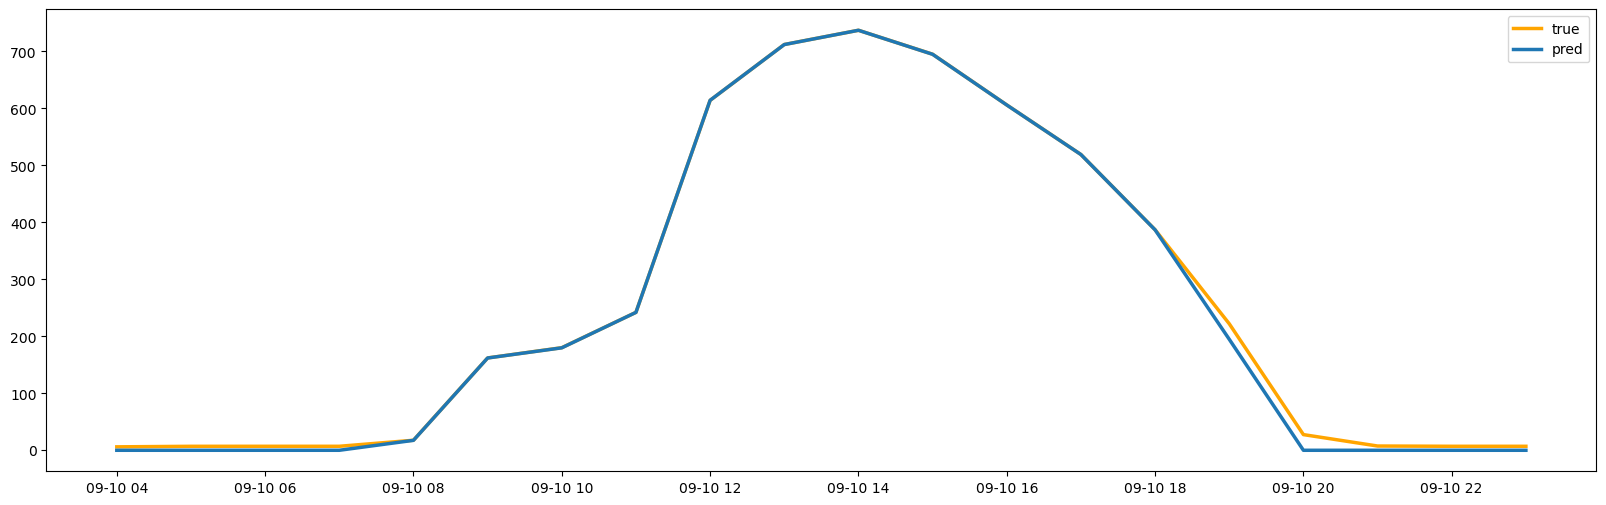

In [225]:
plt.plot(true, label = 'true', color = 'orange')
plt.plot(pred, label = 'pred')
plt.legend()
plt.show()


## More than 20 values


In [1]:
from pso import PSO, CPSO
from tqdm import tqdm

In [2]:
from IPython.display import clear_output

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [58]:
def loss_func(x):
    a = x[0]
    n = x[1]
    ghi_m = torch.Tensor(df['ghi_m'][index:index].to_numpy()).to(device)#.cuda()
    neb = torch.Tensor(df[' nebulosity'][index:index].to_numpy()).to(device)#.cuda()
    ghi_cs = torch.Tensor(df['ghi_cs'][index:index].to_numpy()).to(device)#.cuda()

    diff = torch.square(ghi_m - (1- (a * torch.pow(neb, n)))* ghi_cs)
    loss = diff.sum()
    return loss#.reshape(-1, 1)

w = 0.5  # inertia
c1 = 0.5  # cognitive (particle)
c2 = 0.5  # social (swarm)

lb = [-1, -1]
ub = [1, 1]
xa = []
xn = []
for index, row in df[:'2022-10-01'].iterrows():
    print(index)
    # print(df[index:index])
    val, xopt = PSO(loss_func, 100, 100, 2, w, c1, c2, -1, 1, device)
    print(xopt)
    xa.append(xopt[0][0])
    xn.append(xopt[0][1])
    clear_output(wait=False)

In [59]:
pred = GHI_cs[:'2022-10-01'].copy()
pred.columns = ['pred_']

In [60]:
xa

[tensor(0.6549, device='mps:0'),
 tensor(0.7056, device='mps:0'),
 tensor(0.2357, device='mps:0'),
 tensor(-0.2957, device='mps:0'),
 tensor(0.9401, device='mps:0'),
 tensor(0.8975, device='mps:0'),
 tensor(0.6382, device='mps:0'),
 tensor(0.9494, device='mps:0'),
 tensor(0.6111, device='mps:0'),
 tensor(-0.3675, device='mps:0'),
 tensor(-0.8586, device='mps:0'),
 tensor(0.9974, device='mps:0'),
 tensor(0.0582, device='mps:0'),
 tensor(0.8190, device='mps:0'),
 tensor(0.3070, device='mps:0'),
 tensor(0.9776, device='mps:0'),
 tensor(-0.6714, device='mps:0'),
 tensor(0.6259, device='mps:0'),
 tensor(-0.6898, device='mps:0'),
 tensor(-0.7730, device='mps:0'),
 tensor(-0.1142, device='mps:0'),
 tensor(-0.0389, device='mps:0'),
 tensor(0.3434, device='mps:0'),
 tensor(-0.7514, device='mps:0'),
 tensor(0.0279, device='mps:0'),
 tensor(0.7675, device='mps:0'),
 tensor(0.3887, device='mps:0'),
 tensor(-0.1053, device='mps:0'),
 tensor(0.9519, device='mps:0'),
 tensor(0.2511, device='mps:0'),


In [61]:
xa_ = torch.tensor(xa).detach().cpu()

xn_ = torch.tensor(xn).detach().cpu()

In [45]:
xa_

tensor([ 4.2426,  8.4913, -1.0249, -4.8273, -2.0887,  0.4832, -7.2865,  8.1619,
         6.6480, -9.4651, -7.1819, -4.0341,  0.0945,  1.3779,  3.0612,  0.7460,
         6.1251,  1.8947,  1.0045,  7.5325,  5.6358, -6.3573, -1.4375, -4.9095,
        -8.5915, -8.2160, -0.2203, -3.1038,  0.8184,  0.0449,  5.6070,  9.4673,
         4.4658, -0.0458, -0.6427,  2.3920, -6.5488, -1.5448, -1.6880,  1.1934,
         5.7771, -6.3149, -0.4006,  3.4490, -4.1521, -4.3092,  8.5091,  1.9381,
         1.8280,  7.8849,  5.6875,  9.2451, -7.5939,  6.4000, -6.3108, -5.4811,
         4.4262, -0.2623,  9.6874,  3.8169,  3.3142,  6.2985, -0.9240, -0.3178,
        -2.3350, -4.7760,  4.8789,  6.2829,  9.8619,  7.1972, -5.2144,  7.3059,
        -0.5465, -2.9890,  2.8748, -6.1644,  7.2531, -4.4658,  1.7032,  5.7087,
         4.0903, -6.3959, -7.5725, -4.2306,  6.7027,  3.6649,  9.6786,  8.8520,
        -6.4872,  6.2351,  5.3440, -8.4354, -9.8497,  4.1025, -0.1248, -3.5791,
         7.0421, -8.5909,  5.4903,  6.40

In [62]:
pred['pred_'] = ((1-xa_*np.power(df[' nebulosity'][:'2022-10-01'].values, xn_))* df['ghi_cs'][:'2022-10-01'].to_numpy())

In [63]:
pred['pred_'] = [data if data >= 0 else 0 for data in pred['pred_']] 
pred['pred_'] = [data if data <= 1 else 1 for data in pred['pred_']] 

In [64]:
true =GHI_m[:'2022-10-01']

In [65]:
from sklearn.metrics import mean_squared_error as MSE
testScore = np.sqrt(MSE(true.values, pred.values))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/true.values.max())

Test Score: 0.23 RMSE
RMSE en % :  30.454300276130052


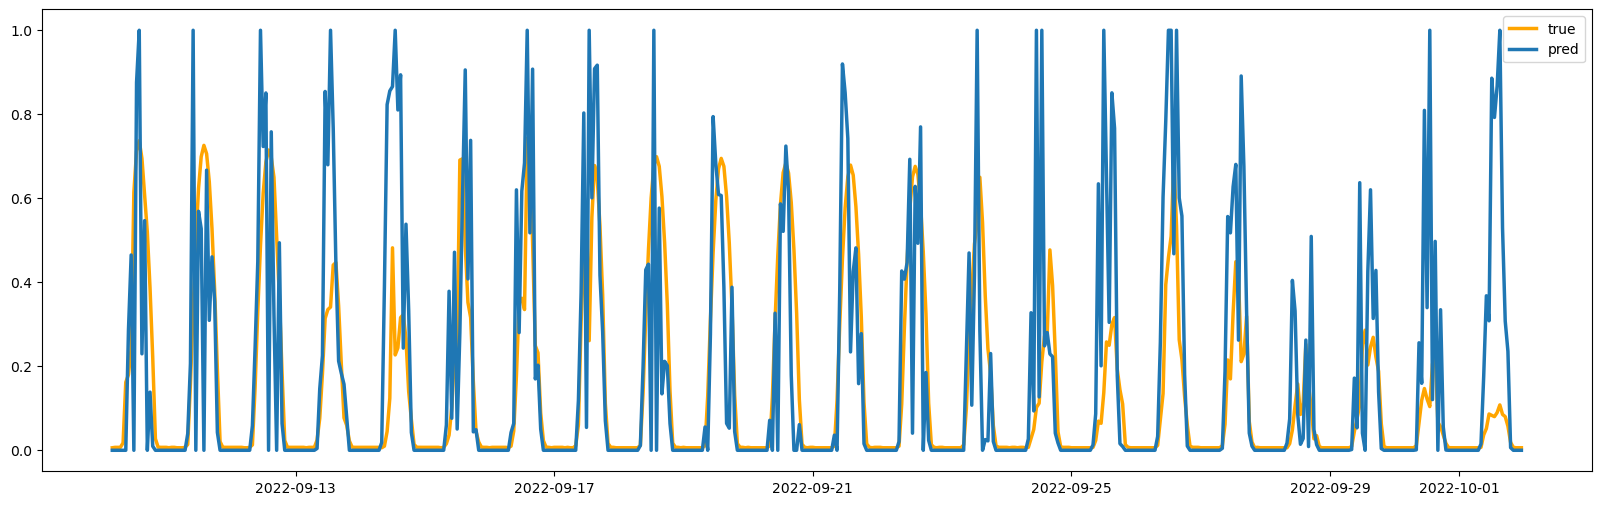

In [66]:
plt.plot(true, label = 'true', color = 'orange')
plt.plot(pred, label = 'pred')
plt.legend()
plt.show()


# Try over every 24 h

In [67]:
from pso import PSO, CPSO
from tqdm import tqdm

In [68]:
from IPython.display import clear_output

In [69]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [143]:
dates = pd.date_range("2023-02-01 12",'2023-06-01', freq="H")
i=0

In [144]:
def loss_func(x):
    a = x[0][0]
    n = x[0][1]
    ghi_m = torch.Tensor(df['ghi_m'][index:dates[i]].to_numpy()).to(device)#.cuda()
    neb = torch.Tensor(df[' nebulosity'][index:dates[i]].to_numpy()).to(device)#.cuda()
    ghi_cs = torch.Tensor(df['ghi_cs'][index:dates[i]].to_numpy()).to(device)#.cuda()


    diff = torch.square(ghi_m - (1- (a * torch.pow(neb, n)))* ghi_cs)
    loss = diff.sum()
    return loss#.reshape(-1, 1)
    # return xa, xn


In [151]:
def predict(start, end):
    w = 0.5  # inertia
    c1 = 0.5  # cognitive (particle)
    c2 = 0.5  # social (swarm)

    lb = [0, 0]
    ub = [1, 10]
    xa = []
    xn = []
    i = 0
    for index, row in df[start:end].iterrows():
        print(index)
        if i % 12 == 0 :
            val, xopt = PSO(loss_func, 100, 100, 2, w, c1, c2, 0, 1, device)
        # print(xopt)
        xa.append(xopt[0][0])
        xn.append(xopt[0][1])
        i+=1

        clear_output(wait=False)

    xa_ = torch.tensor(xa).detach().cpu()

    xn_ = torch.tensor(xn).detach().cpu()
    
    plt.plot(xa_)
    plt.show()
    plt.plot(xn_)
    plt.show()

    pred = GHI_cs[start:end].copy()
    pred.columns = ['pred_']

    pred['pred_'] = ((1-xa_*np.power(df[' nebulosity'][start:end].values, xn_))* df['ghi_cs'][start:end].to_numpy())*1000
    pred['pred_'] = [data if data >= 0 else 0 for data in pred['pred_']] 
    # pred['pred_'] = [data if data <= 1 else 1 for data in pred['pred_']] 
    true =GHI_m[start:end]*1000

    from sklearn.metrics import mean_squared_error as MSE
    testScore = np.sqrt(MSE(true.values, pred.values))
    print('Test Score: %.2f RMSE' % (testScore))
    print('RMSE en % : ', testScore*100/true.values.max())
    plt.plot(true, label = 'true', color = 'orange')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.show()

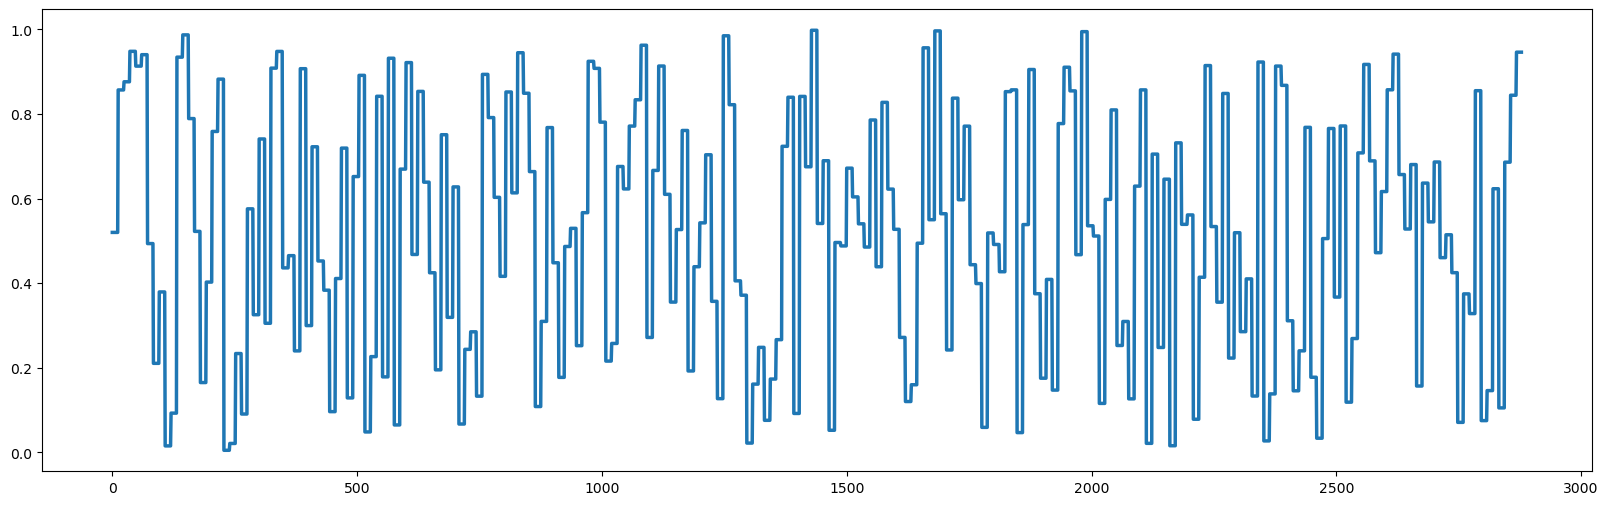

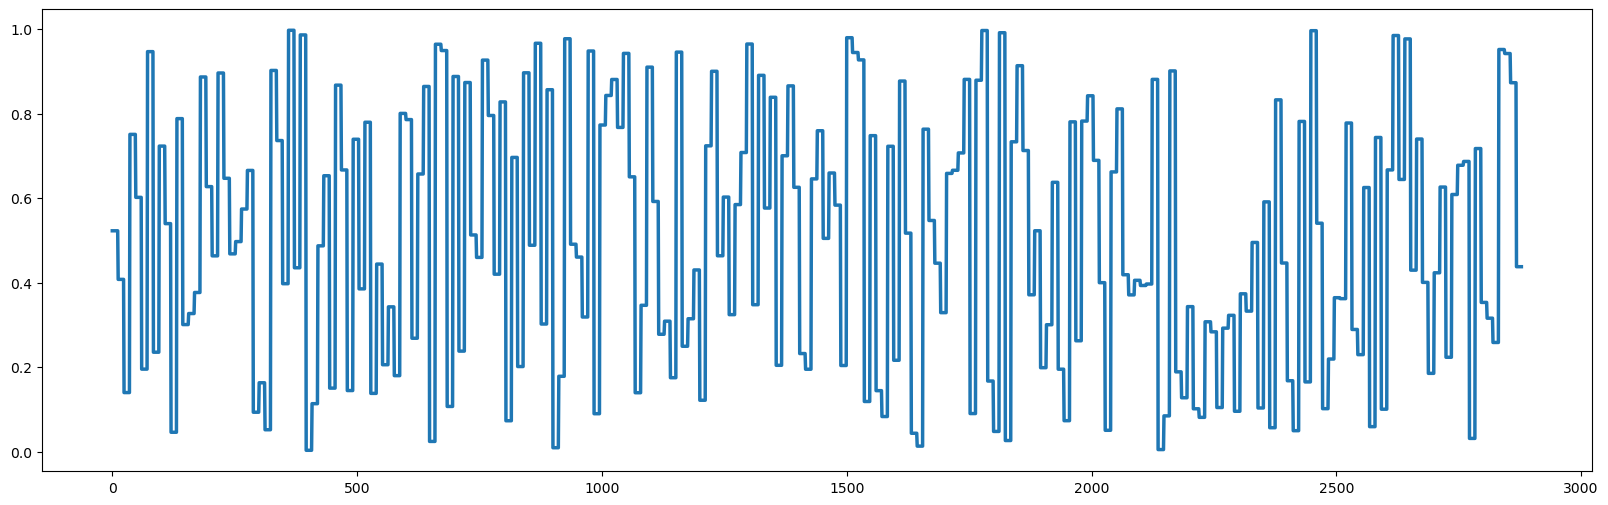

Test Score: 149.23 RMSE
RMSE en % :  16.543825266234823


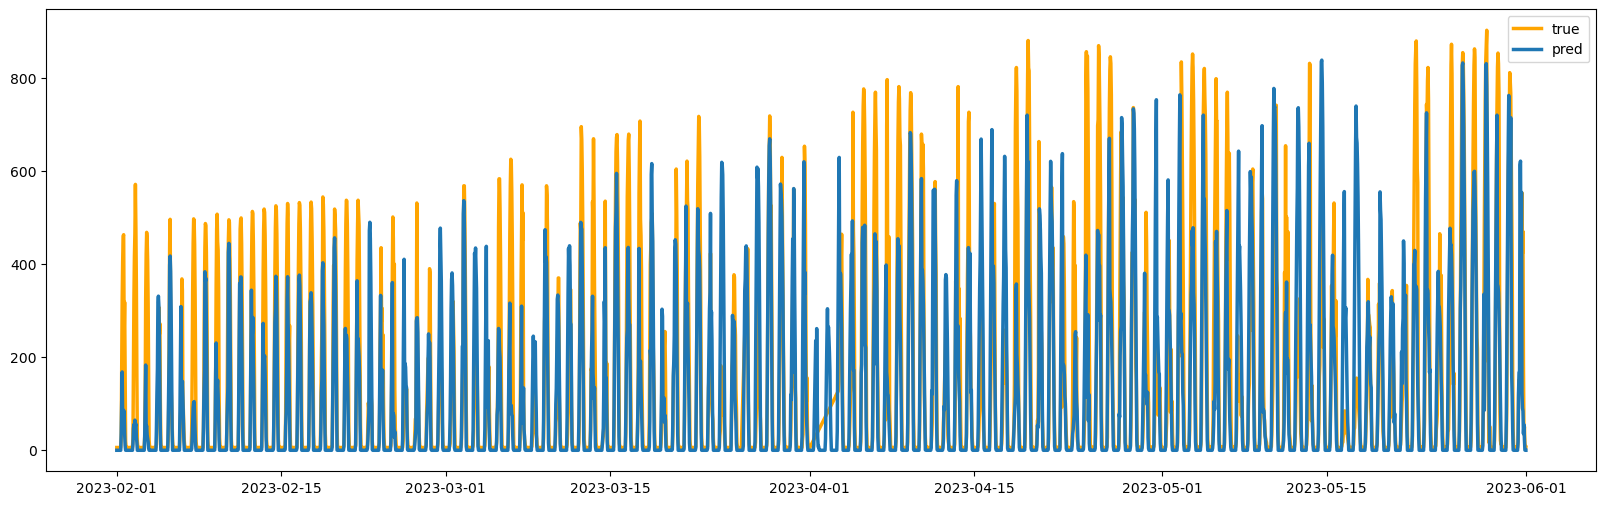

In [152]:

predict('2023-02-01', '2023-05-31')